In [4]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import xtrack as xt
from pathlib import Path
import pandas as pd

from zoneinfo import ZoneInfo
from datetime import timedelta, datetime

In [147]:
file = ak.from_parquet(Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/abwlm/SPS.USER.MD2/2025.06.16.20.04.44.893407.parquet'))

In [149]:
file['ABWLMSPS/Acquisition']['value']['bunchIntensities'][0][:,0]

<Array [3.71e+03, 3.73e+03, 3.73e+03, ..., 0, 0, 0] type='264 * ?float32'>

# Sanity checks for the files

In [3]:
if file['ABWLMSPS/Acquisition']['value']['acquisitionDone'][0]:
    print('Acquisition done')
else:
    print('Acquisition not done')

Acquisition done


In [ ]:
directory = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2')
paths_files_list = list(directory.glob("*.parquet"))
path_files = {}
for path in paths_files_list:
    stem = path.stem
    dt = datetime.strptime(stem, "%Y.%m.%d.%H.%M.%S.%f")
    dt = dt.replace(tzinfo=ZoneInfo("Europe/Paris"))
    path_files[dt] = path
path_files = pd.DataFrame.from_dict(path_files, orient='index', columns=['path'])
path_files.index = pd.to_datetime(path_files.index)
print(path_files.index.is_monotonic_increasing)
path_files = path_files.sort_index() #Files need to be sorted by index for correct time series handling
print(path_files.index.is_monotonic_increasing)

In [69]:
df_params = pd.read_json('../MD_data/20250616/parameters.json').T
df_params.index = pd.to_datetime(df_params.index) #convert index (string timestamp) to datetime
df_params.index = df_params.index.tz_localize("Europe/Paris") #Set to Geneva time
changes_ts = df_params.index.to_numpy()

df_fo = pd.read_json('../MD_data/20250616/full_overview.json').T
df_fo.index = pd.to_datetime(df_fo.index) #convert index (string timestamp) to datetime
df_fo.index = df_fo.index.tz_localize("Europe/Paris") #Set to Geneva time

# Making new dict with paths per timestamp
paths_per_ts = {}
dt = timedelta(seconds=1)
for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()
    
    for i in range(len(ll)):
        if len(lll) > i:
            paths_per_ts[ll[i]] = lll[i]
paths_per_ts = pd.DataFrame.from_dict(paths_per_ts, orient='index', columns=['path'])

In [70]:
paths_per_ts

,path
2025-06-16 11:52:17.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 11:52:59.800000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 11:53:41.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 11:54:23.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 11:55:05.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
...,...
2025-06-16 20:16:37.100000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 20:17:04.700000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 20:17:32.300000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 20:17:59.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...


In [123]:
acq_done = {}
intensities = {}
bunch_lengths = {}
acquisition_timestamps = {}
for p in paths_per_ts.path:
    file = ak.from_parquet(p)
    acq_done[p.stem] = file['ABWLMSPS/Acquisition']['value']['acquisitionDone'][0]
    intensities[p.stem] = file['ABWLMSPS/Acquisition']['value']['bunchIntensities'][0][:,0]
    bunch_lengths[p.stem] = file['ABWLMSPS/Acquisition']['value']['bunchLengths'][0][:,0]
    acquisition_timestamps[p.stem] = file['ABWLMSPS/Acquisition']['value']['acqTimeFromInj'][0]

In [146]:
file['ABWLMSPS/Acquisition']['value']

<Array [{acqTimeFromInj: [0, ...], ...}] type='1 * ?{acqTimeFromInj: option...'>

In [139]:
file['ABWLMSPS/Acquisition']['value']['acqTimeFromInj'][0]

<Array [0, 20, 40, 60, ..., 5.22e+03, 5.24e+03, 5.26e+03] type='264 * ?float64'>

In [80]:
acq_status = np.array(list(acq_done.values()))
np.unique(acq_status, return_counts=True)

(array([ True]), array([106]))

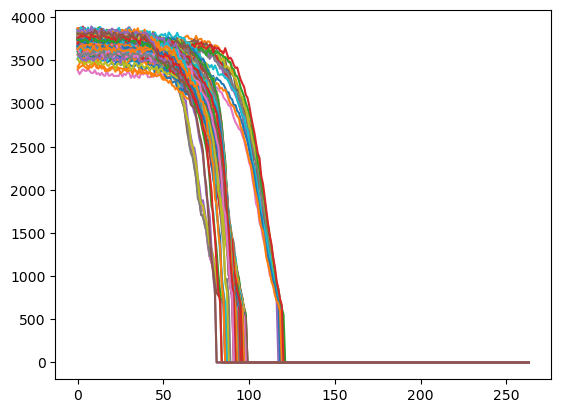

In [81]:
for key in intensities.keys():
    plt.plot(intensities[key], label=key)

We see that all if them have reasonably the same intensity, same intensity curve, and the difference in spread is due to the different radial steering parameters that were used

In [89]:
i_max = [np.max(intensities[key]) for key in intensities.keys()]
bl_max = [np.max(bunch_lengths[key]) for key in bunch_lengths.keys()]

In [90]:
np.unique(i_max)

array([3399.4014, 3471.0657, 3508.468 , 3522.5337, 3562.5352, 3572.268 ,
       3574.3328, 3583.799 , 3599.935 , 3618.001 , 3630.999 , 3632.201 ,
       3635.1335, 3642.5984, 3645.735 , 3648.1345, 3650.8665, 3657.6658,
       3660.    , 3660.532 , 3671.268 , 3672.065 , 3672.668 , 3673.065 ,
       3685.3328, 3685.9343, 3688.6016, 3698.6672, 3699.1345, 3701.7979,
       3702.8665, 3708.065 , 3710.6655, 3720.6672, 3723.2021, 3733.3984,
       3735.5337, 3736.1313, 3740.732 , 3741.5337, 3741.8665, 3745.268 ,
       3750.8655, 3751.001 , 3752.935 , 3758.999 , 3761.1992, 3762.8008,
       3765.8655, 3766.532 , 3766.8665, 3768.    , 3771.668 , 3771.799 ,
       3772.1992, 3774.5337, 3774.6655, 3774.732 , 3775.935 , 3777.    ,
       3777.4663, 3777.5352, 3783.4016, 3784.6672, 3784.733 , 3786.    ,
       3787.732 , 3788.0645, 3789.5337, 3790.6016, 3791.268 , 3801.735 ,
       3802.1345, 3803.7979, 3804.1335, 3810.1313, 3811.532 , 3812.532 ,
       3813.0645, 3814.8008, 3816.268 , 3818.267 , 

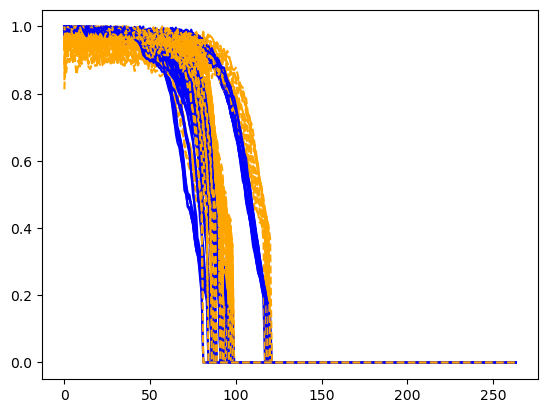

In [141]:
for key in intensities.keys():
    plt.plot(intensities[key]/np.max(intensities[key]), label=key, color='blue')
    plt.plot(bunch_lengths[key]/np.max(bunch_lengths[key]), label=key, color='orange', ls = '--')

In [110]:
i95 = np.array([np.where(intensities[key]/np.max(intensities[key]) < 0.95 )[0][0] for key in intensities.keys()])
i50 = np.array([np.where(intensities[key]/np.max(intensities[key]) < 0.50 )[0][0] for key in intensities.keys()])

In [103]:
ratios = {}

for i, key in enumerate(intensities.keys()):
    ratios[key] = (intensities[key][:i95[i]] / np.max(intensities[key])) / (bunch_lengths[key][:i95[i]] / np.max(bunch_lengths[key]))


In [106]:
intensities[key][:i95[i]] / np.max(intensities[key])/ bunch_lengths[key][:i95[i]] * np.max(bunch_lengths[key])


<Array [] type='0 * ?float32'>

In [107]:
intensities[key][:i95[i]] / np.max(intensities[key])

<Array [] type='0 * ?float32'>

In [113]:
np.mean((intensities[key][:i95[i]] / np.max(intensities[key])) / (bunch_lengths[key][:i95[i]] / np.max(bunch_lengths[key])))

np.float64(1.0088520917025479)

In [115]:
np.std((intensities[key][:i95[i]] / np.max(intensities[key])) / (bunch_lengths[key][:i95[i]] / np.max(bunch_lengths[key])))

np.float64(0.012229825596102578)

ratio between the two should be close to 1, with a 1% error. So we can put margin of 5%... But basically it means that there is not too much of a weird behaviour between intensity and bunch length in theory

In [117]:
mean_ratios = {}
std_ratios = {}
for key in intensities.keys():
    mean_ratios[key] = np.mean((intensities[key][:i95[i]] / np.max(intensities[key])) / (bunch_lengths[key][:i95[i]] / np.max(bunch_lengths[key])))
    std_ratios[key] = np.std((intensities[key][:i95[i]] / np.max(intensities[key])) / (bunch_lengths[key][:i95[i]] / np.max(bunch_lengths[key])))

# Analysis curves

In [ ]:
def interval_means(bl, acq_ts, i95, n_intervals):
    interval_length = (acq_ts[i95] - acq_ts[0]) / n_intervals
    means = []
    for j in range(n_intervals):
        start = acq_ts[0] + j * interval_length
        end = start + interval_length
        mask = (acq_ts >= start) & (acq_ts < end)
        if np.any(mask):
            means.append(np.mean(bl[mask]))
    return means


In [ ]:
interval_means(bunch_lengths[key], acquisition_timestamps[key], i95[i], 100)

[np.float64(3.9784385563734755e-09),
 np.float64(3.955205940542328e-09),
 np.float64(3.989131158732562e-09),
 np.float64(3.986755814366916e-09),
 np.float64(3.957238092766602e-09),
 np.float64(3.988413510569444e-09),
 np.float64(3.985461294320203e-09),
 np.float64(3.964694883507036e-09),
 np.float64(3.986088348284511e-09),
 np.float64(3.961969419208344e-09)]

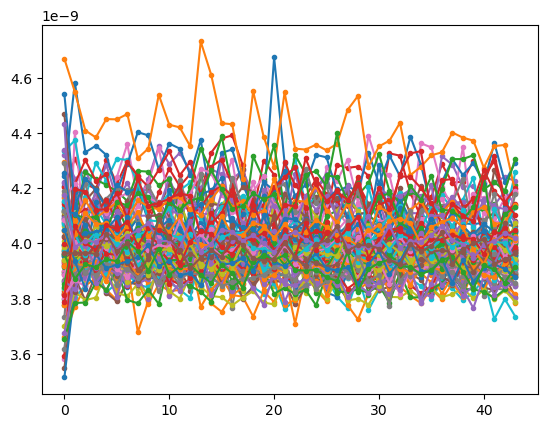

In [133]:
for key in bunch_lengths.keys():
    plt.plot(interval_means(bunch_lengths[key], acquisition_timestamps[key], i95[i], 1000), '.-')

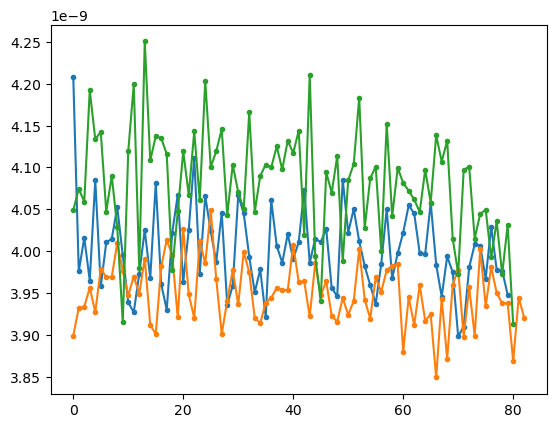

In [138]:
for i, key in enumerate(list(bunch_lengths.keys())[:3]):
    plt.plot(interval_means(bunch_lengths[key], acquisition_timestamps[key], i95[i], 200), '.-')

# Analysis per chroma/cases